In [62]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### EY analysis for the location in Golden



In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvcircuit as pvc
from pvcircuit.PlotWithControls import PlotsWithControls
import ipywidgets as widgets
from scipy import constants
from scipy import integrate
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc

from IPython import display

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode

import os
import sys

from glob import glob
from datetime import datetime, timedelta
import time
from tqdm.notebook import trange
import timeit
import pickle

# set path for NREL meteorological package and import
sys.path.append("../../NREL_Meteorological")
from environmental import Spectra, Meteorological, sync
import warnings
from scipy.optimize import OptimizeWarning
from itertools import cycle
from matplotlib.lines import Line2D
import numba
import math
import pickle


Helpers


In [64]:
warnings.simplefilter("ignore", OptimizeWarning)


In [65]:
def wavelength_to_photonenergy(wavelength):
    return constants.h * constants.c / (wavelength * 1e-9) / constants.e


def photonenergy_to_wavelength(photonenergy):
    return constants.h * constants.c / (photonenergy * 1e-9) / constants.e


def _normalize(eqe: pd.DataFrame) -> pd.DataFrame:
    eqe_min = np.nanmin(eqe)
    eqe_max = np.nanmax(eqe)
    return (eqe - eqe_min) / (eqe_max - eqe_min)


def _eq_solve_Eg(Eg, *data):
    x, y = data
    return np.trapz(x * y, x) / np.trapz(y, x) - Eg


def _gaussian(x, a, x0, sigma):
    return 1 * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def calc_Eg_Rau(eqe, fit_gaussian=True):
    # using [1] U. Rau, B. Blank, T. C. M. Müller, and T. Kirchartz,
    # “Efficiency Potential of Photovoltaic Materials and Devices Unveiled by Detailed-Balance Analysis,”
    # Phys. Rev. Applied, vol. 7, no. 4, p. 044016, Apr. 2017, doi: 10.1103/PhysRevApplied.7.044016.
    # extended by gaussian fit

    # Define the Gaussian function
    wavelength = eqe.index.values
    y = eqe.values
    x = wavelength_to_photonenergy(wavelength)

    # convert wavelength to photon energy
    y_grad = np.abs(np.gradient(y))
    # y_grad = np.abs(np.diff(y.values, prepend=np.nan))
    # y_grad = y.diff().abs().values

    # filter tail to avoid eqe dips at end/beginning of measurement
    y_grad = y_grad[(x < (x.max() + x.min())/2)]
    y = y[(x < (x.max() + x.min())/2)]
    x = x[(x < (x.max() + x.min())/2)]
    # normalize data
    y_grad = _normalize(y_grad)
    # get the index of the maximum
    y_diff_max_idx = np.nanargmax(y_grad)
    # get the max coordinates
    x_diff_max = x[y_diff_max_idx]
    y_diff_max = y_grad[y_diff_max_idx]

    # define lower threshold
    p_ab = np.exp(-2) * y_diff_max
    thres = 0.5
    # p_ab = thres * y_diff_max
    # find the index of the low-energy side where P(a) is max(P(Eg)/2)
    a_cond = np.where((y_grad < p_ab) & (x < x_diff_max))[0]
    if len(a_cond > 0):
        a_idx = np.nanmin(a_cond)
    else:
        a_idx = len(x) - 1
    a = x[a_idx]
    p_a = y_grad[a_idx]
    # find the index of the high-energy side where P(b) is max(P(Eg)/2)
    b_idx = np.nanmax(np.where((y_grad < p_ab) & (x > x_diff_max))[0])
    b = x[b_idx]
    p_b = y_grad[b_idx]

    x_target = x[a_idx : b_idx - 1 : -1]
    y_target = y_grad[a_idx : b_idx - 1 : -1]

    if fit_gaussian:

        # initial guesses from weighted arithmetic mean and weighted sample sigma
        mean = sum(x_target * y_target) / sum(y_target)
        sigma = np.sqrt(sum(y_target * (x_target - mean) ** 2) / sum(y_target))

        fit_res = curve_fit(
            _gaussian,
            x_target,
            y_target,
            p0=[max(y_target), mean, sigma],
        )
        x_fit = np.linspace(x[b_idx], x[a_idx], 100)
        y_fit = _gaussian(x_fit, *fit_res[0])

        # fig,ax = plt.subplots(1)
        # ax.plot(x, y_grad,'.')
        # ax.plot(x_fit, y_fit)
        # ax.plot(x_target, y_target, ".r")
        # ax.plot(x_diff_max, y_diff_max, "r*")
        # ax.plot(a, p_a, "g*")
        # ax.plot(b, p_b, "b*")
        # plt.plot(x_fit - fit_res[0][1], y_fit)
        # plt.plot(x_fit, y_fit)
        # ax.set_xlim(1.1, 1.8)
        # ax.set_ylabel(r"$\frac{{\mathrm{d}}EQE}{{\mathrm{d}}E_{\nu}}$")
        # ax.set_xlabel(r"Photon energy $E_{\nu}$ [eV]")

        x_fit = x_fit[y_fit >= thres * y_fit.max()]
        y_fit = y_fit[y_fit >= thres * y_fit.max()]
        sigma = fit_res[0][2]

    else:
        fit_res = [None]
        x_fit = x_target
        y_fit = y_target
        sigma = None

    res = fsolve(_eq_solve_Eg, 1.0, args=(x_fit, y_fit))
    bandgap = res[0]
    return bandgap, sigma


def si_eg_shift(temperature, bandgap_25):
    p = [-6.47214956e-04, 1.01632828e00]
    return (p[0] * temperature + p[1]) * bandgap_25


def si_sigma_shift(temperature, sigma_25):
    p = [0.00959188, 0.76558903]
    return (p[0] * temperature + p[1])*sigma_25


def psc_eg_shift(temperature, bandgap_25):
    t_split = 32
    p = [2.59551019e-04, 9.91138163e-01]
    res = np.zeros_like(temperature)

    t_filter = temperature > t_split
    res[t_filter] = p[0] * temperature[t_filter] + p[1]
    res[~t_filter] = p[0] * t_split + p[1]
    # res = pd.Series(res, index = temperature.index)
    return res * bandgap_25


def psc_sigma_shift(temperature, sigma_25):
    p = [0.00358866, 0.90074156]
    return (p[0] * temperature + p[1])*sigma_25

def intergrate_eqe(eqe):
    path_to_am15_spectra = os.path.join(os.path.dirname(os.getcwd()), "data","ASTMG173.csv")  # Data files here
    # spectra = pd.read_csv(path_to_am15_spectra, header=[*range(0,3)])
    spectra_full = pd.read_csv(path_to_am15_spectra, header=[2])
    spectra_full.set_index(spectra_full.columns[0], inplace=True)

    spectra = spectra_full.reindex(eqe.index)
    if spectra.isnull().any(axis=1).any():
        spectra = spectra.reindex(index=eqe.index).interpolate(method="index")

    # jsc = (
    #     eqe.apply(lambda x: np.trapz(y=x * spectra["global"] / qe._wavelength_to_photonenergy(eqe.index), x=eqe.index)) / 10
    # )
    jsc = np.trapz(y=eqe.values * spectra["global"] / wavelength_to_photonenergy(eqe.index), x=eqe.index) / 10
    
    
    return jsc
    si_fit = np.polyfit(temperature_silicon, jsc[1:], 1)

    temps = np.linspace(min(temperature_silicon), max(temperature_silicon), 50)
    jsc_fit = np.polyval(si_fit, temps)

    fig, ax = plt.subplots(1)
    ax.plot(temperature_silicon, jsc[1:], "*", temps, jsc_fit)

# @numba.jit()
def shift_eqe(eqe_ref, bandgap_25, sigma_25, bandgaps, sigmas, spectra):

    eqe = eqe_ref.values
    lam = eqe_ref.index.values
    Ey = constants.h * constants.c / (lam * 1e-9) / constants.e  # [eV]
    
    # abs = 1 / 2 * erfc((bandgap_25 - Ey) / (sigma_25 * np.sqrt(2)))

    lam_eqe_saturation_idx = np.argmax(eqe * lam)
    eqe_saturation = eqe[lam_eqe_saturation_idx]
    # lam_eqe_saturation = lam[lam_eqe_saturation_idx]

    # jscs = []
    # # fig,ax = plt.subplots()
    # for i, col in enumerate(bandgaps):
    #     # print(qe_data.temperature)
    #     spec = spectra.iloc[i][lam]
    #     bandgap = bandgaps[i]
    #     sigma = sigmas[i]
    #     abs = 1 / 2 * erfc((bandgap - Ey) / (sigma * np.sqrt(2))) * eqe_saturation
    #     eqe_filter = lam > photonenergy_to_wavelength(bandgap + 2*sigma)
    #     eqe_new = np.concatenate([eqe[~eqe_filter],abs[eqe_filter]])
    #     # ax.plot(eqe_new)
    #     jscs.append(np.trapz(y = eqe_new * spec / wavelength_to_photonenergy(spec.index), x = spec.index) / 10)
    
    spec_interp_func = interp1d(spectra.index, spectra,axis=0)

    spectra_interp = pd.DataFrame(spec_interp_func(spectra.index.astype(np.float64)), index = spectra.index)

    
    bandgaps_arr = np.tile(bandgaps, [len(Ey), 1])
    sigmas_arr = np.tile(sigmas, [len(Ey), 1])
    erfc_arr = (bandgaps_arr - Ey.reshape(-1,1)) / (sigmas_arr * np.sqrt(2))
    vec_erfc = np.vectorize(erfc)
    abs_arr = vec_erfc(erfc_arr) * 0.5 * eqe_saturation
    eqe_filter = np.tile(lam,[len(bandgaps),1]).T > photonenergy_to_wavelength(bandgaps_arr + 2*sigmas_arr)
    eqe_new_arr = np.tile(eqe,[len(bandgaps),1]).T    
    eqe_new_arr = eqe_new_arr * ~eqe_filter + abs_arr * eqe_filter
    # jscs = np.trapz(y = eqe_new_arr * spectra[lam].values.T  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    jscs = np.trapz(y = eqe_new_arr * spectra_interp[lam].values.reshape(-1,1)  / wavelength_to_photonenergy(lam).reshape(-1,1), x = lam.reshape(-1,1),axis=0) / 10
    
    # print(f"check jscs = {all(jscs_arr == np.array(jscs))}")
    
    return jscs
    


Some notebook settings

In [66]:
t_elaps = None
t_elapsMP = None

squeeze_day_to_one_day = True # squeezes the meteo data into one day to allow plot comparison in one day
results = None

Load the meteorological data

In [67]:
def get_meteo(date_start, date_end, resampler):
    
    # date_start = datetime(2022, 6, 15, 0, 0, 0)  # sunny day
    # date_end = date_start + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    meteo_data = Meteorological.get_midc_environmental(date_start, date_end)
    # spectra_class = Spectra.get_srrl_wiser_global_track(date_start, date_end)
    spectra_class = Spectra.get_srrl_solarsim_direct_normal(date_start, date_end)
    
    

    # resample
    spectra_resampled = spectra_class.spectra.resample(resampler).median()
    meteo_resampled = meteo_data.data.resample(resampler).median()

    spectra_sync, meteo_sync = sync(spectra_resampled, meteo_resampled)

    # remove nan
    nan_filter = spectra_sync.isna().any(axis=1) | meteo_sync.isna().any(axis=1)
    spectra_sync = spectra_sync[~nan_filter]
    meteo_sync = meteo_sync[~nan_filter]
    
    #remove negative spectral data
    spec_filter = (spectra_sync<-1).any(axis=1)
    spectra_sync = spectra_sync[~spec_filter]
    meteo_sync = meteo_sync[~spec_filter]

    # if squeeze_days_to_one_day:
    #     meteo_data.data.index = meteo_data.data.index.map(lambda dt: dt.replace(day=1))
    
    # import TMY data of meteo_location
    meteo_location = pvc.Meteo(
        wavelength=spectra_sync.columns.astype(int),
        spectra=spectra_sync,
        ambient_temperature=meteo_sync["Deck Dry Bulb Temp [deg C]"],
        wind=meteo_sync["Avg Wind Speed @ 19ft [m/s]"],
        daytime=spectra_sync.index,
    )
    return meteo_location


Hard code scenarios for cell data

In [68]:
def get_jv_params(fp_psk_jv, fp_si_jv, plot_fits:bool=False):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

    psk_data = pd.read_csv(os.path.join(path, fp_psk_jv))
    A = 1  # [cm^2]
    TC = 25  # [degC]

    # Measured terminal voltage.
    voltage = psk_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = psk_data["i"].to_numpy(np.double) / 1000 * A  # [A/cm^2]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
        voltage, current
    )
    ilim = 0.6
    while psc_params[2] < 0:
        ilim -=0.01        
        # fit iv
        psc_params = fit_sandia_simple(  # [A/cm^2]  # [A/cm^2]  # [Ohm cm^2]  # [Ohm cm^2]
            voltage, current, ilim=ilim
        )
        
    if plot_fits:
        fit = singlediode(*psc_params, ivcurve_pnts=30)
        fig,ax = plt.subplots()
        ax.plot(voltage,current,"k*",label="psc-data")
        ax.plot(fit["v"],fit["i"],"k--",label="psc-fit")
        
        
    si_data = pd.read_csv(os.path.join(path, fp_si_jv))
    # Measured terminal voltage.
    voltage = si_data["v"].to_numpy(np.double)  # [V]
    # Measured terminal current.
    current = si_data["i"].to_numpy(np.double) / 1000 * A  # [A]

    sort_id = np.argsort(voltage)

    voltage = voltage[sort_id]
    current = current[sort_id]

    voc_guess_idx = np.where(current >= 0)[0][-1]
    voc_guess_idx
    voltage = voltage[: voc_guess_idx + 2]
    current = current[: voc_guess_idx + 2]

    # fit iv
    si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
        voltage, current
    )
    ilim = 0.6
    while si_params[2] < 0:
        ilim -=0.01        
        # fit iv
        si_params = fit_sandia_simple(  # [A]  # [A]  # [Ohm]  # [Ohm]
            voltage, current, ilim=ilim
        )
    
    if plot_fits:
        fit = singlediode(*si_params, ivcurve_pnts=30)
        ax.plot(voltage,current,"rx",label="Si-data")
        ax.plot(fit["v"],fit["i"], "r--",label="Si-fit")
        
    return psc_params, si_params

In [69]:
def get_tandem_eqe(fp_psk_eqe, fp_psk_trans, fp_si_eqe, psc_params, si_params):
    
    # get the Silicon paramters
    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params
    
    A = 1  # [cm^2]
    TC = 25  # [degC]
    
    reader_settings = {"index_col": 0, "usecols": [0, 1]}
    df_psk_eqe = pd.read_excel(fp_psk_eqe, **reader_settings).dropna().squeeze("columns")
    df_psk_trans = pd.read_csv(fp_psk_trans, **reader_settings).dropna().squeeze("columns")
    df_si_eqe = pd.read_excel(fp_si_eqe, **reader_settings).dropna().squeeze("columns")

    df_psk_trans = None
    if df_psk_trans is None:
        df_psk_trans = 1 - _normalize(df_psk_eqe)
        
    # in case values are percentages
    if any(df_psk_eqe.values > 1):
        df_psk_eqe = df_psk_eqe.div(100)
    if any(df_psk_trans.values > 1):
        df_psk_trans = df_psk_trans.div(100)
    if any(df_si_eqe.values > 1):
        df_si_eqe = df_si_eqe.div(100)

    # # round in case wavelength has many floating points
    df_psk_eqe.index = np.round(df_psk_eqe.index.astype(np.double), 1)
    df_psk_trans.index = np.round(df_psk_trans.index.astype(np.double), 1)
    df_si_eqe.index = np.round(df_si_eqe.index.astype(np.double), 1)

    # integrate the EQE and compare the Jsc with the Jsc form the IV data. Assumption here is that the Jsc from IV measurement is the true value and EQE needs to be scaled
    eqe_scaler = psc_isc / A * 1e3 / intergrate_eqe(df_psk_eqe)
    df_psk_eqe = df_psk_eqe * eqe_scaler

    eqe_scaler = si_isc / A * 1e3 / intergrate_eqe(df_si_eqe)
    df_si_eqe = df_si_eqe * eqe_scaler

    # interpolate with eqe's superseding transmission wavelengths
    comb_lam = df_psk_eqe.index.union(df_si_eqe.index)
    df_psk_eqe_interp = df_psk_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    df_psk_trans_interp = df_psk_trans.reindex(index=comb_lam).interpolate(method="index")
    df_si_eqe_interp = df_si_eqe.reindex(index=comb_lam, fill_value=0.0).interpolate(method="index")
    
    
    eqe_max_idx = df_psk_eqe_interp.idxmax()
    filter_idx = (df_psk_eqe_interp.values < 0.01) & (df_psk_trans_interp.index.values > eqe_max_idx)
    df_psk_trans_interp[filter_idx] = 1

    df_si_eqe_filtered = df_psk_trans_interp * df_si_eqe_interp

    # get the bandgap to cut-off eqe of bottom cell where eqe of the top cell is weak
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    lam_cut_psc = photonenergy_to_wavelength(eg_psc + 2 * sigma_psc)

    df_si_eqe_filtered[df_psk_eqe_interp.index <= lam_cut_psc] = 0

    # commbine Psk and filter EQE
    df_tandem_eqe = pd.concat([df_psk_eqe_interp, df_si_eqe_filtered], axis=1)
    df_tandem_eqe.columns = ["Psk", "Si"]
    
    
    return df_tandem_eqe, df_si_eqe_interp


In [70]:
def match_eqe_spectra(df_tandem_eqe, spectra_sync):
    spectra_sync = spectra_sync.reindex(df_tandem_eqe.index,axis=1)
    spec_filter = ~spectra_sync.isna().all()
    spectra_sync = spectra_sync.iloc[:,spec_filter.values]
    df_tandem_eqe = df_tandem_eqe[spec_filter]
    return df_tandem_eqe, spectra_sync

In [71]:
def get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si):

    (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    (si_isc,si_io, si_rs, si_rsh, si_nNsVth) = si_params


    jo_scale = 1000
    A = 1  # [cm^2]
    TC = 25  # [degC]

    psc_jsc = psc_isc / A  # [A/cm^2]
    psc_jo = psc_io / A
    psc_n = psc_nNsVth / pvc.junction.Vth(TC)
    psc_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_psc)
    psc_joratio = jo_scale * psc_jo / (psc_jdb * jo_scale) ** (1.0 / psc_n)
    psc_joratio = 300

    psc_rser = psc_rs * A
    psc_gsh = 1 / (psc_rsh * A)

    si_jsc = si_isc / A  # [A/cm^2]
    si_jo = si_io / A
    si_n = si_nNsVth / pvc.junction.Vth(TC)
    si_jdb = pvc.junction.Jdb(TC=TC, Eg=eg_si)
    si_joratio = jo_scale * si_jo / (si_jdb * jo_scale) ** (1.0 / si_n)
    
    si_jsc = intergrate_eqe(df_si_eqe_filtered) / 1e3
    

    si_rser = si_rs * A
    si_gsh = 1 / (si_rsh * A)

    dev3T = pvc.Tandem3T()
    dev3T.set(name="PskSidev3T", Rz=0)
    dev3T.top.set(Eg=eg_psc, J0ratio=[psc_joratio], Jext=psc_jsc, Gsh=psc_gsh, Rser=psc_rser, n=[psc_n], beta = 0, JLC = 0)
    dev3T.bot.set(Eg=eg_si, J0ratio=[si_joratio], Jext=si_jsc, Gsh=si_gsh, Rser=si_rser, n=[si_n], beta = 0, JLC = 0)
    return dev3T

In [72]:
def run_single_core(model, meteo_location):
    iref = 1  # global
    ncells = 60

    operlist = pvc.EY.VMlist(2)
    operlist.remove("VM11")
    num = len(operlist)
    ratio = [0] * num
    sEY = [0] * num
    rEY = [0] * num
    sEYeff = [0] * num
    rEYeff = [0] * num
    sSTCeff = [0] * num
    rSTCeff = [0] * num
    sloss = [0] * num
    rloss = [0] * num

    t_start = time.perf_counter()
    for i, oper in enumerate(operlist):
        model.bot.set(pn=1)  # s-type
        bot, top, ratio[i], type3T = pvc.EY.cellmodeldesc(model, oper)
        sloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
        sSTCeff[i] = meteo_location.cellSTCeff(model, oper)
        # sEY[i], sEYeff[i] = meteo_location.STC(model, oper)

        if oper in ["MPP", "CM"]:
            rEY[i], rEYeff[i] = sEY[i], sEYeff[i]

        else:
            model.bot.set(pn=-1)  # r-type
            bot, top, ratio[i], type3T = pvc.EY.cellmodeldesc(model, oper)
            rloss[i] = pvc.EY.VMloss(type3T, bot, top, ncells)
            rSTCeff[i] = meteo_location.cellSTCeff(model, oper)
            # rEY[i], rEYeff[i] = meteo_location.cellEYeff(model, oper)
    t_elaps = time.perf_counter() - t_start
    return sEY, rEY, sEYeff, rEYeff, sSTCeff, rSTCeff, sloss, rloss, ratio, t_elaps


In [73]:
def run_multi_core(model, meteo_location):

    iref = 1  # global
    ncells = 60
    model = dev3T  # pointer?

    operlist = pvc.EY.VMlist(2)
    operlist.remove("VM11")
    num = len(operlist)
    ratio = [0] * num
    sEYeff_MP = [0] * num
    rEYeff_MP = [0] * num
    sEY_MP = [0] * num
    rEY_MP = [0] * num
    sSTCeff = [0] * num
    rSTCeff = [0] * num
    sloss = [0] * num
    rloss = [0] * num

    t_start = time.perf_counter()
    for idx, oper in enumerate(operlist):
        # for idx in trange(len(operlist)):
        oper = operlist[idx]
        model.bot.set(pn=1)  # s-type
        bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
        sSTCeff[idx] = meteo_location.cellSTCeff(model, oper)

        model.bot.set(pn=-1)  # r-type
        bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
        rSTCeff[idx] = meteo_location.cellSTCeff(model, oper)

    for idx, oper in enumerate(operlist):
        # for idx in trange(len(operlist)):
        oper = operlist[idx]
        model.bot.set(pn=1)  # s-type
        bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
        sloss[idx] = pvc.EY.VMloss(type3T, bot, top, ncells)
        sEY_MP[idx], sEYeff_MP[idx] = meteo_location.cellEYeffMP(model, oper)

        if oper in ["MPP", "CM"]:
            rEY_MP[idx], rEYeff_MP[idx] = sEY_MP[idx], sEYeff_MP[idx]

        else:
            model.bot.set(pn=-1)  # r-type
            bot, top, ratio[idx], type3T = pvc.EY.cellmodeldesc(model, oper)
            rloss[idx] = pvc.EY.VMloss(type3T, bot, top, ncells)
            rEY_MP[idx], rEYeff_MP[idx] = meteo_location.cellEYeffMP(model, oper)
    t_elapsMP = time.perf_counter() - t_start
    return sEY_MP, rEY_MP, sEYeff_MP, rEYeff_MP, sSTCeff, rSTCeff, sloss, rloss, ratio, t_elapsMP


In [74]:
# import EQE of Psk and Tandem
# Transmittance data
# Pvsk_1.53eV_Qi_3-22_tr.csv
# Pvsk_1.60eV_Qi_3-22_tr.csv
# Pvsk_1.63eV_Qi_3-22_tr.csv
# Pvsk_1.70eV_Qi_3-22_tr.csv

# PSC EQE data
# Pvsk_1.25eV_QE.xlsx
# Pvsk_1.63MA-free_QE.xlsx
# Pvsk_1.68eV_QE.xlsx
# Pvsk_1.70MA-free_QE.xlsx
# Pvsk_1.75MA-free_QE.xlsx
# Pvsk_1.80MA-free_QE.xlsx
path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here

datalist = glob(path + "**" + os.path.sep +"*")
# print(*(f"{i:>2} --> {os.path.basename(x)}" for i, x in enumerate(datalist)), sep="\n")

fp_psk_eqe = {
    1.25 : [file for file in datalist if "1.25" in file and "_QE" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_QE" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_QE" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_QE" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_QE" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_QE" in file][0]
}

fp_psk_trans = {
    1.25 : [file for file in datalist if "1.53" in file and "_tr" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.68 : [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.75 : [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.80 : [file for file in datalist if "1.70" in file and "_tr" in file][0]
}

fp_psk_jv = {
    1.25 : [file for file in datalist if "1.25" in file and "_JV" in file][0],
    1.63 : [file for file in datalist if "1.63" in file and "_JV" in file][0],
    1.68 : [file for file in datalist if "1.68" in file and "_JV" in file][0],
    1.70 : [file for file in datalist if "1.70" in file and "_JV" in file][0],
    1.75 : [file for file in datalist if "1.75" in file and "_JV" in file][0],
    1.80 : [file for file in datalist if "1.80" in file and "_JV" in file][0]
}


# file_psk_trans = "Pvsk0111D_1.7sb_tr.csv"
fp_si_eqe = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_QE.xlsx" in file][0] 
fp_si_jv = [file for file in datalist if "Si_101_E1_005_14_2B_postITO_JV.csv" in file][0]




16.835315096608326

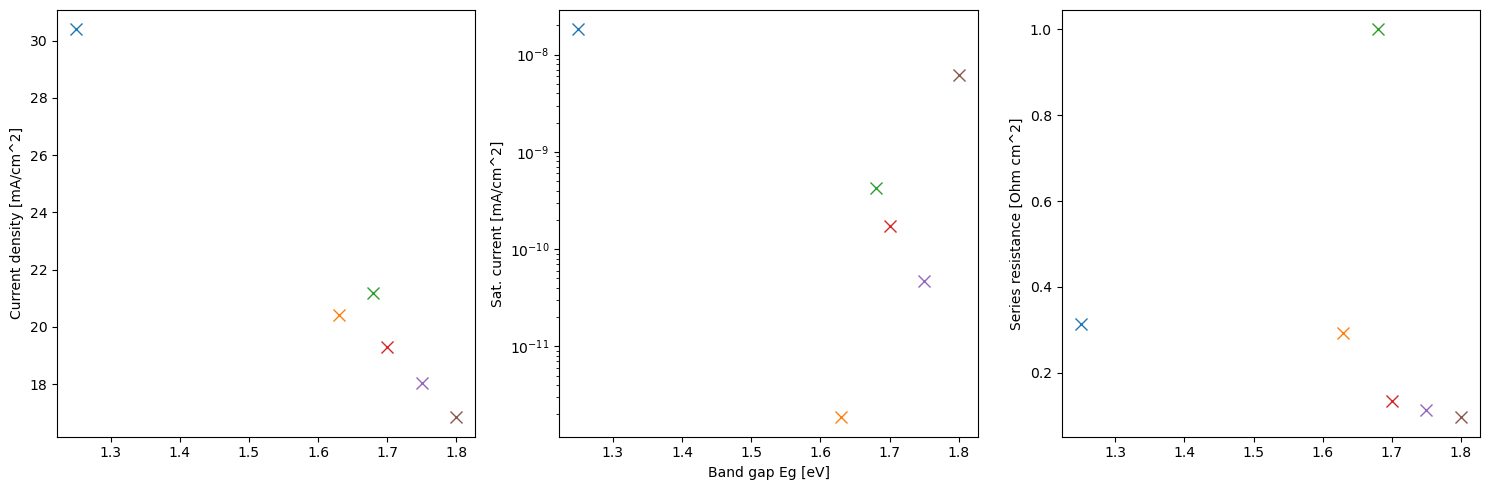

In [75]:
fig,ax = plt.subplots(1,3,sharex=True,figsize=(15, 5))
for eg in fp_psk_eqe.keys():
    
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
    ax[0].plot(eg,psc_params[0]*1e3,"x")
    ax[1].plot(eg,psc_params[1]*1e3,"x")
    ax[2].plot(eg,psc_params[2],"x")
ax[1].set_yscale("log")

ax[1].set_xlabel("Band gap Eg [eV]")
ax[0].set_ylabel("Current density [mA/cm^2]")
ax[1].set_ylabel("Sat. current [mA/cm^2]")
ax[2].set_ylabel("Series resistance [Ohm cm^2]")
plt.tight_layout()
psc_params[0] * 1e3

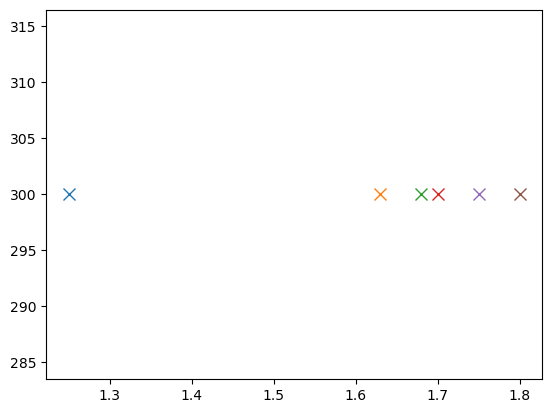

In [76]:
fig,ax = plt.subplots(1)

for eg in fp_psk_eqe.keys():
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
    

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    ax.plot(eg,dev3T.top.J0ratio,"x")
    
    # fig,ax = plt.subplots(1,3,sharex=True,figsize=(15, 5))

In [77]:
Eg = list(fp_psk_eqe.keys())[0]

psc_params, si_params = get_jv_params(fp_psk_jv[Eg], fp_si_jv)
df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[Eg], fp_psk_trans[Eg], fp_si_eqe, psc_params, si_params)
df_psk_eqe_interp = df_tandem_eqe.iloc[:,0]
df_si_eqe_filtered = df_tandem_eqe.iloc[:,1]

eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)

eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)



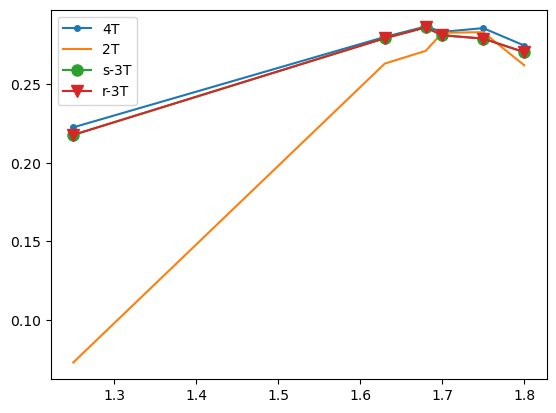

In [78]:
egs = []
# [model.oper for model in meteo_location.models]
operation_modes = []

tandem_types = []
etas = []

Rz = 0


eta_real = pd.DataFrame(np.zeros([len(fp_psk_eqe.keys()), 4]), index = list(fp_psk_eqe.keys()), columns = ["4T", "2T", "s-3T", "r-3T"])


for eg in fp_psk_eqe.keys():
    
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:,0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:,1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
    eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

    eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
    lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

    EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
    EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg, eg_si)
    # dev3T.top.set(Rser=Rz)
    
    iv3t = dev3T.MPP()
    eta_real["4T"].loc[eg] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_real["2T"].loc[eg] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_real["s-3T"].loc[eg] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_real["r-3T"].loc[eg] = iv3t.Ptot[0] * 10
    

markers = cycle(Line2D.markers)
fig, ax = plt.subplots(1)
lines = ax.plot(eta_real)
for line in lines:
    line.set_marker(next(markers))
leg = ax.legend(eta_real.columns)

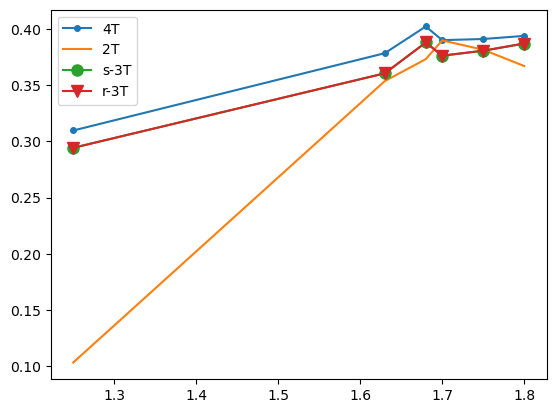

In [79]:
eta_norecombination = pd.DataFrame(np.zeros([len(fp_psk_eqe.keys()), 4]), index = list(fp_psk_eqe.keys()), columns = ["4T", "2T", "s-3T", "r-3T"])


for eg_psc in fp_psk_eqe.keys():
    
    psc_params, si_params = get_jv_params(fp_psk_jv[eg_psc], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg_psc], fp_psk_trans[eg_psc], fp_si_eqe, psc_params, si_params)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:,0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:,1]

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    # dev3T.top.set(Rser=Rz)
    dev3T.set(Rz=Rz)
    # dev2T = pvc.Multi2T.from_3T(dev3T)
    
    dev3T.top.set(n = [1], J0ratio = [1], Rser = 0, Gsh = 0)
    dev3T.bot.set(n = [1], J0ratio = [1], Rser = 0, Gsh = 0)
    
    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_norecombination["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_norecombination["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_norecombination["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_norecombination["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
markers = cycle(Line2D.markers)
fig, ax = plt.subplots(1)
lines = ax.plot(eta_norecombination)
for line in lines:
    line.set_marker(next(markers))
leg = ax.legend(eta_real.columns)

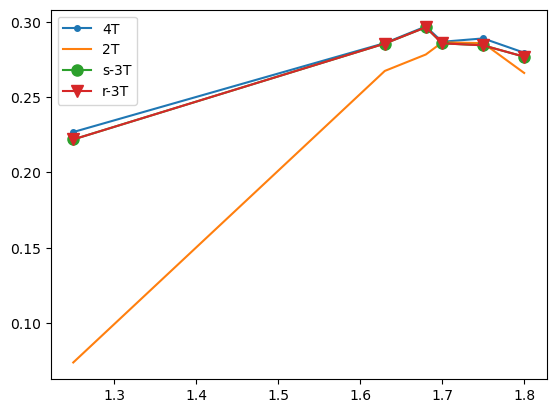

In [80]:
eta_nors = pd.DataFrame(np.zeros([len(fp_psk_eqe.keys()), 4]), index = list(fp_psk_eqe.keys()), columns = ["4T", "2T", "s-3T", "r-3T"])


for eg_psc in fp_psk_eqe.keys():
    
    psc_params, si_params = get_jv_params(fp_psk_jv[eg_psc], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg_psc], fp_psk_trans[eg_psc], fp_si_eqe, psc_params, si_params)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:,0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:,1]

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    dev3T.set(Rz=Rz)
    # dev2T = pvc.Multi2T.from_3T(dev3T)
    
    dev3T.top.set(Rser = 0, Gsh = 0)
    dev3T.bot.set(Rser = 0, Gsh = 0)
    
    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_nors["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_nors["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_nors["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_nors["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
markers = cycle(Line2D.markers)
fig, ax = plt.subplots(1)
lines = ax.plot(eta_nors)
for line in lines:
    line.set_marker(next(markers))
leg = ax.legend(eta_real.columns)

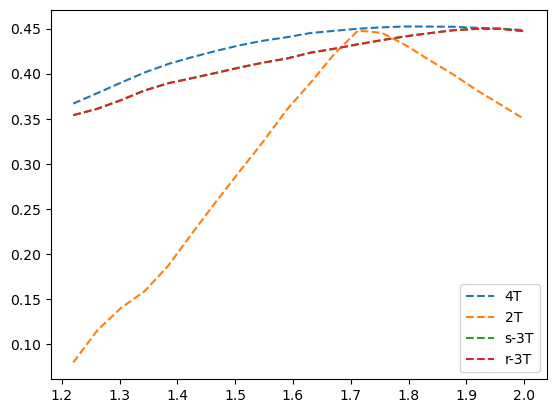

In [81]:
Rz = 0

eg_si = 1.12

egs = np.linspace(eg_si + 0.1,2,20)
eta_ideal = pd.DataFrame(np.zeros([len(egs), 4]), index = egs, columns = ["4T", "2T", "s-3T", "r-3T"])

for eg_psc in egs:
    
    lam_thres = np.round(photonenergy_to_wavelength(eg_psc))
    
    lam_top = np.arange(300,lam_thres,1)
    lam_bot = np.arange(lam_thres,photonenergy_to_wavelength(eg_si))
    
    eqe_top = pvc.EQE(np.ones(lam_top.shape), lam_top, "Psk")  # EQE class
    eqe_bot = pvc.EQE(np.ones(lam_bot.shape), lam_bot, "Si")  # EQE class
    jext_top = eqe_top.Jint()
    jext_bot = eqe_bot.Jint()
    
    dev3T = pvc.Tandem3T()
    
    dev3T.top.set(Rser=Rz)
    dev3T.set(Rz=Rz)
    # dev2T = pvc.Multi2T.from_3T(dev3T)
    
    dev3T.top.set(Jext = jext_top / 1e3, n = [1], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_psc, beta = 0)
    dev3T.bot.set(Jext = jext_bot / 1e3, n = [1], J0ratio = [1], Rser = 0, Gsh = 0, JLC = 0, Eg = eg_si, beta = 0)
    
    dev3T.bot.set(pn=1)  # s-type
    
    iv3t = dev3T.MPP()
    eta_ideal["4T"].loc[eg_psc] = iv3t.Ptot[0] * 10

    _, iv3t = dev3T.CM()
    eta_ideal["2T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    _, iv3t = dev3T.VM(2,1)
    eta_ideal["s-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
    dev3T.bot.set(pn=-1)  # r-type
    _, iv3t = dev3T.VM(2,1)
    eta_ideal["r-3T"].loc[eg_psc] = iv3t.Ptot[0] * 10
    
fig, ax = plt.subplots(1)
ax.plot(eta_ideal, linestyle="--")
leg = ax.legend(eta_ideal.columns)

In [82]:
eta_ideal

,4T,2T,s-3T,r-3T
1.220000,0.366780,0.079697,0.353946,0.353946
1.261053,0.378202,0.114832,0.360899,0.360899
1.302105,0.389873,0.139981,0.370497,0.370497
1.343158,0.401185,0.158531,0.381262,0.381262
1.384211,0.410702,0.186920,0.389340,0.389340
1.425263,0.418244,0.222656,0.395010,0.395010
1.466316,0.425093,0.257486,0.400745,0.400745
1.507368,0.431385,0.291287,0.406720,0.406720
1.548421,0.436518,0.324588,0.412199,0.412199
1.589474,0.440369,0.360107,0.416783,0.416783


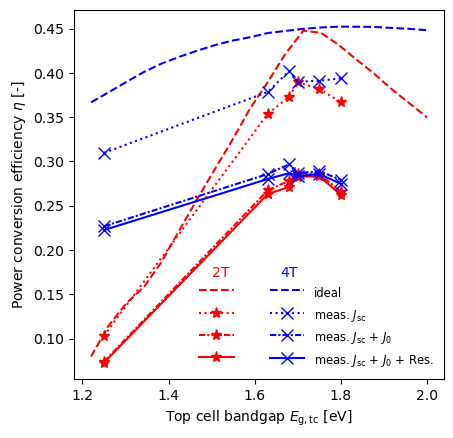

In [83]:
plt.rcParams["lines.markersize"] = 8
fig, ax = plt.subplots(1)
ax.plot(eta_ideal[["2T"]], "r--", label=" ")
ax.plot(eta_norecombination[["2T"]],"r:*", label=" ")
ax.plot(eta_nors[["2T"]],"r*", linestyle=(0, (3, 1, 1, 1)), label=" ")
ax.plot(eta_real[["2T"]], "r-*", label=" ")

ax.plot(eta_ideal[["4T"]], "b--", label="ideal")
ax.plot(eta_norecombination[["4T"]],"b:x", label="meas. $J_\mathrm{sc}$")
ax.plot(eta_nors[["4T"]],"bx", linestyle=(0, (3, 1, 1, 1)), label="meas. $J_\mathrm{sc}$ + $J_\mathrm{0}$")
ax.plot(eta_real[["4T"]], "b-x", label="meas. $J_\mathrm{sc}$ + $J_\mathrm{0}$ + Res.")

leg = ax.legend(ncol=2,loc='lower right', frameon=False, fontsize='small', handlelength=3, handleheight=1.8)
plt.draw()
# p = leg.get_position()

ax.annotate('2T', (1.5, 0.17), 
            xycoords='data', color="r")
ax.annotate('4T', (1.66, 0.17), 
            xycoords='data', color="b")

ax.set_xlabel("Top cell bandgap $E_\mathrm{g,tc}$ [eV]")
ax.set_ylabel("Power conversion efficiency $\\eta$ [-]")
ax.set_box_aspect(1)
leg

In [84]:
date_start = datetime(2021, 11, 1, 0, 0, 0)

# date_start = date_end - pd.Timedelta(days=1) + pd.Timedelta(seconds=1)
# date_end = date_start.replace(day=date_start.day + 7) - pd.Timedelta(seconds=1)
# date_end = date_start.replace(month=date_start.month+1) - pd.Timedelta(seconds=1)
# date_end = date_start.replace(year=date_start.year + 1) - pd.Timedelta(seconds=1)

date_end = datetime(2022, 11, 1, 0, 0, 0) - pd.Timedelta(seconds=1)

# meteo_location = get_meteo(date_start, date_end, "1T")

# with open("meteo_year.p", "wb") as fout:
#     pickle.dump(meteo_location,fout)
    

with open("meteo_year.p", "rb") as fin:
    meteo_location = pickle.load(fin)


# print("calculating currents")

# currents = pd.DataFrame(
#     np.zeros([meteo_location.spectra.shape[0], len(fp_psk_eqe.keys()) * 2]),
#     index=meteo_location.spectra.index,
#     columns=[
#         f"{jsc}_{eg}"
#         for jsc, eg in zip(
#             ["Jsctop", "Jscbot"] * len(list(fp_psk_eqe.keys())), [eg for eg in list(fp_psk_eqe.keys()) for _ in range(2)]
#         )
#     ],
# )

# for idx, eg in enumerate(fp_psk_eqe.keys()):

#     psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
#     df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
#     # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
#     df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
#     df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

#     # dev3T.top.set(Rser=Rz)

#     # spectra = wiser_global_horizontal.spectra.loc[date_plot]
#     spectra = meteo_location.spectra.T
#     spectra.index = meteo_location.wavelength

#     spectra_interp = spectra.reindex(index=df_psk_eqe_interp.index).interpolate(method="index")

#     # spectra = wiser_global_horizontal.spectra.loc[date_start:date_end].T
#     Jsc_top = np.trapz(
#         constants.e
#         / constants.h
#         / constants.c
#         * spectra_interp.index.values.reshape(-1, 1)
#         * spectra_interp.values
#         * df_psk_eqe_interp.values.reshape(-1, 1)
#         * 1e-10,
#         x=spectra_interp.index,
#         axis=0,
#     )
#     Jsc_bottom = np.trapz(
#         constants.e / constants.h / constants.c * spectra_interp.index.values.reshape(-1, 1) * spectra_interp.values
#         # * df_si_eqe_interp.values
#         * df_si_eqe_filtered.values.reshape(-1, 1) * 1e-10,
#         x=spectra_interp.index,
#         axis=0,
#     )

#     currents.iloc[:, 2 * idx] = Jsc_top
#     currents.iloc[:, 2 * idx + 1] = Jsc_bottom
    
# # remove negative currents
# neg_current_mask = (currents > 0).all(axis=1)
# currents = currents[neg_current_mask]

# markers = cycle(Line2D.markers)
# fig, ax = plt.subplots(1)
# lines = ax.plot(currents)
# for line in lines:
#     line.set_marker(next(markers))
# leg = ax.legend(currents.columns)


Determine average photon energy (APE)

In [278]:
# np.trapz(x=meteo_location.wavelength.values.astype(int),y=meteo_location.spectra) # slow but correct if wavelength distance is not 1nm

phi = meteo_location.spectra * (meteo_location.wavelength.values.astype(int) * 1e-9) / constants.h / constants.c
average_photon_energy = np.trapz(meteo_location.spectra) / constants.e / np.trapz(phi)


Filter irrelevant energies


In [279]:
ape_mask = (average_photon_energy > 0) & (average_photon_energy < 4) & ((meteo_location.spectra > -1e-2).all(axis=1))
average_photon_energy = average_photon_energy[ape_mask]
spectra = meteo_location.spectra[ape_mask]
spec_powers = meteo_location.SpecPower[ape_mask]
ape_temps = meteo_location.TempCell[ape_mask]

Bin APE

In [322]:
nr_of_ape_bins = 3
nr_of_temp_bins = 20
ape_bins = pd.cut(average_photon_energy,nr_of_ape_bins)

Do the binning by cumulative energy

array([ 80922.,  61373., 123275.])

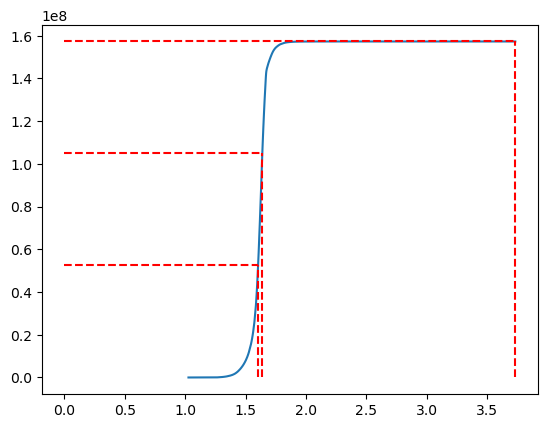

In [327]:
ape_dataframe = pd.DataFrame(
    {"timestamps": ape_temps.index, "power": spec_powers, "temperature": ape_temps}, index=average_photon_energy
)
ape_dataframe = ape_dataframe.sort_index()
ape_dataframe["powerCumSum"] = ape_dataframe["power"].cumsum()
total_power = ape_dataframe["powerCumSum"].iloc[-1]
bin_power = total_power / nr_of_ape_bins

ax = ape_dataframe["powerCumSum"].plot()
bin_edges = np.zeros(nr_of_ape_bins + 1)
bin_counts = np.zeros(nr_of_ape_bins)
for ape_bin in range(1, nr_of_ape_bins + 1):
    max_idx = ape_dataframe["powerCumSum"][ape_dataframe["powerCumSum"] <= ape_bin * bin_power].dropna().index[-1]
    bin_edges[ape_bin] = max_idx
    ax.plot([0, max_idx], [ape_bin * bin_power, ape_bin * bin_power], "r--")
    ax.plot([max_idx, max_idx], [0 * bin_power, ape_bin * bin_power], "r--")
    bin_counts[ape_bin - 1] = len(ape_dataframe[(ape_dataframe.index > bin_edges[ape_bin - 1]) & (ape_dataframe.index <= bin_edges[ape_bin])])

bin_edges
bin_counts


In [313]:
len(bin_counts)

31

Loop over all APE bins and average the spectra. Assign each spectra a time delta. Multiply the correspondig spectrum with the time delta. Sum over all spectra and divide by the total time in that bin.

In [121]:
ape_bins_unique = ape_bins.value_counts()
ape_spectra = pd.DataFrame(np.zeros([len(ape_bins_unique), len(spectra.columns)]), index = ape_bins_unique, columns = spectra.columns)
irradiance = []
for idx, ape_bin in enumerate(ape_bins_unique.index):
    ape_bin_mask = ape_bins == ape_bin

    bin_spectra = spectra[ape_bin_mask]
    bin_times = bin_spectra.index

    bin_time_deltas = bin_times.to_series().diff().astype(np.int64)/1e9
    _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
    # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
    bin_time_deltas[day_idx] = 60

    ape_spectra.iloc[idx,:] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1,1)) / np.sum(bin_time_deltas)
    
    
    # bin temperature in each bin
    bin_temps = ape_temps[ape_bin_mask]
    irradiance.append(np.trapz(x=ape_spectra.columns.astype(np.float32), y=ape_spectra.iloc[idx,:]))


In [ ]:
ape_bins_unique = ape_bins.value_counts()

ape_spectra = pd.DataFrame(np.zeros([len(ape_bins_unique), len(spectra.columns)]), index = ape_bins_unique, columns = spectra.columns)

egs = list(fp_psk_eqe.keys())

cols = ["Eg",
        "totalTime",
        "binCount",
        "ape",
        "temp",
        "ape_bin",
        "temp_bin",
        "powerIn",
        "powerOut",
        "power4T",
        "psc_jscs",
        "si_jscs"
        ]
eta_missmatch = pd.DataFrame(
    np.zeros([len(egs) * nr_of_ape_bins * nr_of_temp_bins, len(cols)]), columns=cols
)

row_counter = 0

for ape_bin_id in trange(len(ape_bins_unique)):
    
    ape_bin = ape_bins_unique.index[ape_bin_id]
    
    ape_bin_mask = ape_bins == ape_bin
    
    if not any(ape_bin_mask):
        continue

    bin_spectra = spectra[ape_bin_mask]
    bin_times = bin_spectra.index

    bin_time_deltas = bin_times.to_series().diff().astype(np.int64)/1e9
    _, day_idx = np.unique(bin_time_deltas.index.date, return_index=True)
    # assume that the time delta at the beginning of a day is 60 seconds to avoid night artifacts
    bin_time_deltas[day_idx] = 60

    ape_spectra.iloc[idx,:] = np.sum(bin_spectra * bin_time_deltas.values.reshape(-1,1)) / np.sum(bin_time_deltas)
    
    # bin temperature in each bin
    bin_temps = pd.cut(ape_temps[ape_bin_mask], bins = nr_of_temp_bins)
    bin_temps_unique = bin_temps.value_counts()
    
    for bin_temp in bin_temps_unique.index:
        
        bin_temp_mask = bin_temps == bin_temp
        
        if not any(bin_temp_mask):
            continue
    
        bin_temp_times = bin_time_deltas[bin_temp_mask]
        
        for id_eg in range(len(egs)):
            eg = egs[id_eg]
            psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
            df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
            # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
            df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
            df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

            eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
            eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)

            eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
            egs_si = si_eg_shift(bin_temp.mid, eg_si)
            sigmas_si = si_sigma_shift(bin_temp.mid, sigma_si)

            eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
            egs_psc = psc_eg_shift(bin_temp.mid, eg_psc)
            sigmas_psc = psc_sigma_shift(bin_temp.mid, sigma_psc)

            si_jscs = shift_eqe(df_si_eqe_filtered, eg_si, sigma_si, [egs_si], [sigmas_si], ape_spectra.iloc[idx,:])
            psc_jscs = shift_eqe(df_psk_eqe_interp, eg_psc, sigma_psc, [egs_psc], [sigmas_psc], ape_spectra.iloc[idx,:])

            # make numpy
            # si_jscs = pd.DataFrame(si_jscs, index=ape_spectra.columns, columns=["si_jscs"])
            # psc_jscs = pd.DataFrame(psc_jscs, index=ape_spectra.columns, columns=["psc_jscs"])

            eqe = df_tandem_eqe.to_numpy(dtype=np.float64, copy=True)
            lam = df_tandem_eqe.index.to_numpy(dtype=np.float64, copy=True)

            EQE2J = pvc.EQE(eqe, lam, "Psk-Si")  # EQE class
            EQE2J.sjuncs = ["Psk", "Si"]  # rename junctions

            dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
            
            powerIn = np.trapz(x=ape_spectra.columns, y=ape_spectra.iloc[idx,:])
            # top_current = bottom_current_bin.mid + current_diff_bin.mid



            if psc_jscs < 0:
                powerOut = 0
                # eta_missmatch[eg].iloc[i]
            else:
                dev3T.top.set(Jext=np.round(psc_jscs, 3) / 1e3,TC=bin_temp.mid, Eg=egs_psc)
                dev3T.bot.set(Jext=np.round(si_jscs, 3) / 1e3,TC=bin_temp.mid, Eg=egs_si)

                _, iv3t = dev3T.CM()
                # powerIn.append(np.trapz(spec))
                powerOut = iv3t.Ptot[0]
                iv3t = dev3T.MPP()
                power4T = iv3t.Ptot[0]
                
            eta_missmatch.at[row_counter, "Eg"] = eg
            eta_missmatch.at[row_counter, "totalTime"] = np.sum(bin_temp_times)
            eta_missmatch.at[row_counter, "binCount"] = bin_temps_unique[bin_temp]
            eta_missmatch.at[row_counter, "ape"] = ape_bin.mid
            eta_missmatch.at[row_counter, "temp"] = bin_temp.mid
            eta_missmatch.at[row_counter, "ape_bin"] = ape_bin
            eta_missmatch.at[row_counter, "temp_bin"] = bin_temp
            eta_missmatch.at[row_counter, "powerIn"] = powerIn
            eta_missmatch.at[row_counter, "powerOut"] = powerOut
            eta_missmatch.at[row_counter, "power4T"] = power4T
            eta_missmatch.at[row_counter, "psc_jscs"] = psc_jscs
            eta_missmatch.at[row_counter, "si_jscs"] = si_jscs
            row_counter += 1


In [ ]:
eta_missmatch_clean = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]
eta_missmatch_clean


In [ ]:
eta_missmatch_clean = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

eta_missmatch_g = eta_missmatch_clean.groupby(["Eg"])
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 3

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()

eta_group = eta_group[eta_group["binCount"]>0]

# bin_energy = eta_group["bin_count"] * eta_group["powerIn"]
# scatter_size = (bin_energy - min(eta_group["bin_count"] * eta_group["powerIn"])) / max(eta_group["bin_count"] * eta_group["Pin"]) * 1500
# # scatter_size = (bin_energy - min(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"])) / max(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"]) * 1500

fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
sp = ax.scatter(
    eta_group["si_jscs"],
    eta_group["psc_jscs"],
    eta_group["temp"]*2,
    # (eta_group["powerIn"] * eta_group["totalTime"])/5e5,
    (eta_group["powerOut"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    marker=".",
    cmap=cmap,
    # norm = "log",
    # vmin=0,
    # vmax = max_eta
)
plt.colorbar(sp, ax=ax, orientation="vertical", label="Energy harvesting efficiency $EHE$ [-]")

# # current matches lines
# ax.plot([0, max_current], [0, max_current], "k--")
max_current = max(eta_group["si_jscs"].max(), eta_group["psc_jscs"].max())
# # limits
ax.set_xlim(0, 1.05*max_current)
ax.set_ylim(0, 1.05*max_current)
# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {eta_group.shape[0]} bins")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
# anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
ax.set_box_aspect(1)

In [ ]:
ape_bins_unique[:]

In [ ]:
eta_missmatch_clean = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

eta_missmatch_g = eta_missmatch_clean.groupby(["Eg"])
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 3

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()

# bin_energy = eta_group["bin_count"] * eta_group["powerIn"]
# scatter_size = (bin_energy - min(eta_group["bin_count"] * eta_group["powerIn"])) / max(eta_group["bin_count"] * eta_group["Pin"]) * 1500
# # scatter_size = (bin_energy - min(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"])) / max(eta_missmatch_clean["bin_count"] * eta_missmatch_clean["Pin"]) * 1500

fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
ax.plot(
    (eta_group["powerIn"] * eta_group["totalTime"]),
    (eta_group["powerOut"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    ".",
)

ax.plot(
    (eta_group["powerIn"] * eta_group["totalTime"]),
    (eta_group["power4T"] * eta_group["totalTime"]) / (eta_group["powerIn"] * eta_group["totalTime"]) * 1e4,
    "r.",
)


# # current matches lines
# ax.plot([0, max_current], [0, max_current], "k--")

# # limits
# ax.set_xlim(0, max_current)
ax.set_ylim(0,0.40)
# # captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV - {eta_group.shape[0]} bins")
ax.set_xlabel("Bottom cell current $J_\mathrm{sc,bot}$ [mA cm$^{-2}$]")
ax.set_ylabel("Top cell current $J_\mathrm{sc,top}$ [mA cm$^{-2}$]")
# anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.3f}",xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)
# anno = ax.annotate(f"$\\eta_\mathrm{{median}}$ = {median_group_eta:.3f}" ,xy=(0.15,0.8), xycoords='figure fraction', fontsize=12)




In [ ]:

dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)

bin_mids = np.array([x.mid for x in eta_group["top_current_bin"].unique()])
eta_group["current_diff"] = (eta_group["topcurrent"] - eta_group["bottomcurrent"])
eta_group["bin_energy"] = eta_group["bin_count"] * eta_group["Pin"]
eta_group["eta"] = eta_group["Pout"] / eta_group["Pin"] * 1e4


eta_group_groups = eta_group.groupby("current_diff").sum()
eta_group_groups[abs(eta_group_groups.index) > 4]["bin_energy"].sum() / eta_group_groups["bin_energy"].sum()
eta_group[eta_group["eta"] < 0.24]["bin_count"].sum() / eta_group["bin_count"].sum()
# plt.scatter(eta_group["Pin"], eta_group["eta"], None, eta_group["bin_count"])
# plt.plot(eta_group["Pin"], eta_group["eta"], None, eta_group["bin_count"])

In [ ]:

egs = list(fp_psk_eqe.keys())
eg = egs[2]
psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)
eg_psc, sigma_psc = calc_Eg_Rau(df_psk_eqe_interp)
dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
# dev3T = pvc.Tandem3T()
# dev3T.top.pn = 1
# dev3T.top.J0ratio = dev3T.bot.J0ratio
# dev3T.top.Eg = dev3T.bot.Eg
# dev3T.top.n = dev3T.bot.n
# dev3T.top.Rser = 0
# dev3T.top.Gsh = 0
# dev3T.bot.Rser = 0
# dev3T.bot.Gsh = 0



dev2T = pvc.Multi2T.from_3T(dev3T)
ratios = np.linspace(0.3,1.7,20)

etas = []
etas2T = []
jsctop = []
jscbot = []
for ratio in ratios:
    dev3T.top.Jext = dev3T.bot.Jext * ratio
    dev2T.j[0].Jext = dev2T.j[1].Jext * ratio
    
    _, iv3t = dev3T.CM()
    etas.append(iv3t.Ptot[0])
    jsctop.append(dev3T.top.Jext)
    jscbot.append(dev3T.bot.Jext)
    etas2T.append(dev2T.MPP()['Pmp'])
    
fig,ax = plt.subplots(1)
ax.plot(ratios, etas)
ax.plot(ratios, etas2T)
# ax2=ax.twinx()
# ax2.plot(ratios, jsctop)
# ax2.plot(ratios, jscbot)

In [ ]:
for id_eg in trange(len(egs)):
    eg = egs[id_eg]
    psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
    df_tandem_eqe, df_si_eqe_interp = get_tandem_eqe(fp_psk_eqe[eg], fp_psk_trans[eg], fp_si_eqe, psc_params, si_params)
    # df_tandem_eqe, meteo_location.spectra = match_eqe_spectra(df_tandem_eqe, meteo_location.spectra)
    df_psk_eqe_interp = df_tandem_eqe.iloc[:, 0]
    df_si_eqe_filtered = df_tandem_eqe.iloc[:, 1]

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)

    eg_si, sigma_si = calc_Eg_Rau(df_si_eqe_interp)

    dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
    
    fig,ax = plt.subplots(1,3,sharex=True,figsize=(15, 5))
    for eg in fp_psk_eqe.keys():
        
        psc_params, si_params = get_jv_params(fp_psk_jv[eg], fp_si_jv)
        # (psc_isc, psc_io, psc_rs, psc_rsh, psc_nNsVth) = psc_params
        ax[0].plot(eg,psc_params[0]*1e3,"x")
        ax[1].plot(eg,psc_params[1]*1e3,"x")
        ax[2].plot(eg,psc_params[2],"x")
    ax[1].set_yscale("log")

    ax[1].set_xlabel("Band gap Eg [eV]")
    ax[0].set_ylabel("Current density [mA/cm^2]")
    ax[1].set_ylabel("Sat. current [mA/cm^2]")
    ax[2].set_ylabel("Series resistance [Ohm cm^2]")
    plt.tight_layout()
    psc_params[0] * 1e3
    

In [ ]:
dev3T = get_tandem_device(psc_params, si_params, df_si_eqe_filtered, eg_psc, eg_si)
_, iv3t = dev3T.CM()
iv3t.Ptot[0]


In [ ]:
eta_missmatch_clean = eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

eta_missmatch_g = eta_missmatch_clean.groupby("Eg")
group_names = list(eta_missmatch_g.groups.keys())

n_choose = 2

eta_group = eta_missmatch_g.get_group(group_names[n_choose]).copy()

max_current = max(si_jscs.max().values[0], psc_jscs.max().values[0])
max_eta = max(eta_missmatch_clean["Pout"] / eta_missmatch_clean["Pin"] * 1e4)
max_eta = 0.4
max_group_eta = max(eta_group["Pout"] / eta_group["Pin"] * 1e4)
mean_group_eta = np.mean(eta_group["Pout"] / eta_group["Pin"] * 1e4)

bin_energy = eta_group["bin_count"] * eta_group["Pin"]
scatter_size = (bin_energy - min(bin_energy)) / (max(bin_energy) - min(bin_energy)) * 500

temps = eta_group["Tcell"].apply(lambda x:x.mid)
fig, ax = plt.subplots()
cmap = plt.colormaps.get("plasma")
# sp = plt.scatter(eta_group["bot_mid"], eta_group["bot_mid"] + eta_group["diff_mid"],eta_group["Pout"]/eta_group["Pin"]*1e4 * 1e2, eta_group["bin_count"],marker="*", cmap=cmap)
sp = ax.scatter(
    temps,
    eta_group["Pout"] / eta_group["Pin"] * 1e4,
    scatter_size,
    eta_group["Pout"] / eta_group["Pin"] * 1e4,
    marker=".",
    cmap=cmap,
    # norm = "log",
    vmin=0,
    vmax = max_eta
)
plt.colorbar(sp, ax=ax, orientation="vertical", label="Conversion efficiency $\\eta$ [1]")

# current matches lines

# limits# captions
ax.set_title(f"TC bandgap {group_names[n_choose]} eV")
ax.set_xlabel("Temperature $T$ [C]")
ax.set_ylabel("Conversion efficiency $\\eta$ [1]")
anno = ax.annotate(f"$\\eta_\mathrm{{mean}}$ = {mean_group_eta:.2f}",xy=(0.15,0.8), xycoords='figure fraction')

In [ ]:
eta_missmatch[~(eta_missmatch == 0).all(axis=1)]

In [ ]:
# with open("2023-01-08_run1_tcbc-binvar.p", "wb" ) as fout:
#     pickle.dump(eta_missmatch,fout)
# # all(test == eta_missmatch)

In [ ]:
with open("2023-01-08_run1_tcbc-binvar.p", "rb" ) as fin:
    test = pickle.load(fin)
all(test == eta_missmatch)

In [ ]:
Rz = 0

eg_si = 1.12

egs = np.linspace(eg_si + 0.1,2,30)
currents_ideal = pd.DataFrame(np.zeros([meteo_location.spectra.shape[0], len(egs) * 2]), index = meteo_location.spectra.index, columns = [f"{jsc}_{eg}" for jsc,eg in zip(["Jsctop","Jscbot"] * len(egs), [eg for eg in egs for _ in range(2)])])

for idx, eg_psc in enumerate(egs):
    
    lam_thres = np.round(photonenergy_to_wavelength(eg_psc))
    
    # lam_top = np.arange(300,lam_thres,1)
    # lam_bot = np.arange(lam_thres,photonenergy_to_wavelength(eg_si))
    
    # eqe_top = np.ones(lam_top.shape)
    # eqe_bot = np.ones(lam_bot.shape)
    
    lam = np.arange(300,photonenergy_to_wavelength(eg_si),1)
    eqe_top = np.ones(lam.shape)
    eqe_bot = np.ones(lam.shape)
    
    eqe_top[lam > lam_thres] = 0
    eqe_bot[lam <= lam_thres] = 0
    
    # spectra = wiser_global_horizontal.spectra.loc[date_plot]
    
    spectra = meteo_location.spectra.T
    spectra.index = meteo_location.wavelength

    spectra_interp = spectra.reindex(index=np.concatenate([lam_top, lam_bot])).interpolate(method="index")

    # spectra = wiser_global_horizontal.spectra.loc[date_start:date_end].T
    Jsc_top = integrate.trapezoid(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1,1)
        * spectra_interp.values
        * eqe_top.reshape(-1,1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )
    Jsc_bottom = integrate.trapezoid(
        constants.e
        / constants.h
        / constants.c
        * spectra_interp.index.values.reshape(-1,1)
        * spectra_interp.values
        # * df_si_eqe_interp.values
        * eqe_bot.reshape(-1,1)
        * 1e-10,
        x=spectra_interp.index,
        axis=0,
    )

    currents_ideal.iloc[:,2 * idx] = Jsc_top
    currents_ideal.iloc[:,2 * idx + 1] = Jsc_bottom
    
currents_ideal = currents_ideal[(currents_ideal > 0).all(axis=1)]
    
    


In [ ]:
eta_missmatch_clean
eta_missmatch_g = eta_missmatch_clean.groupby(["Eg","all_bins"])
group_names = list(eta_missmatch_g.groups.keys())

energy_out = []
energy_bins = []
for group_name in group_names:
    if group_name[0] == list(fp_psk_eqe.keys())[1]:
        current_group = eta_missmatch_g.get_group(group_name)
        energy_bins.append(current_group.shape[0])
        energy_out.append(sum(current_group["Pout"] * current_group["bin_count"]))
plt.plot(energy_bins, energy_out,".")

In [ ]:
eta_group.shape[0]

In [ ]:
plt.plot(eta_group["topcurrent"] - eta_group["bottomcurrent"], eta_group["P4T"] / eta_group["Pin"] * 1e4, "x")
plt.plot(eta_group["topcurrent"] - eta_group["bottomcurrent"], eta_group["Pout"] / eta_group["Pin"] * 1e4, "x")